In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary
!pip install torchmetrics
import torchmetrics

     |████████████████████████████████| 409 kB 5.2 MB/s 


## Carga del dataset CIFAR10

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Aplicamos transformaciones incluyendo la normalización

In [32]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.RandomHorizontalFlip(0.5),
                    torchvision.transforms.ColorJitter(saturation=0.05, hue=0.05),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform= data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
valid_set_size = 5000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))

Tamaño del conjunto de entrenamiento: 45000
Tamaño del conjunto de validación: 5000


In [34]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=45, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)

## Carga del modelo base

In [17]:
vgg11_model = torchvision.models.vgg11(pretrained=True)

vgg11_model.to("cuda")

torchsummary.summary(vgg11_model, input_size=(3, 32, 32))
vgg11_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

## Congelar capas base

In [18]:
for param in vgg11_model.parameters():
    param.requires_grad = False

In [19]:
last_layer_in_features = vgg11_model.classifier[-1].in_features
vgg11_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [20]:
optimizer_ft = torch.optim.Adam(vgg11_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [23]:
result_model, history = train(vgg11_model, criterion, optimizer_ft, train_loader, valid_loader, 30)

Epoch: 1/30 - Train loss 1.031241 - Train Accuracy 0.638467 - Valid Loss 0.967570 - Valid Accuracy 0.669400
Epoch: 2/30 - Train loss 1.031441 - Train Accuracy 0.639978 - Valid Loss 0.964094 - Valid Accuracy 0.674400
Epoch: 3/30 - Train loss 1.035288 - Train Accuracy 0.640422 - Valid Loss 0.964044 - Valid Accuracy 0.667800
Epoch: 4/30 - Train loss 1.030847 - Train Accuracy 0.639600 - Valid Loss 0.967177 - Valid Accuracy 0.666000
Epoch: 5/30 - Train loss 1.035088 - Train Accuracy 0.638133 - Valid Loss 0.963873 - Valid Accuracy 0.670200
Epoch: 6/30 - Train loss 1.026935 - Train Accuracy 0.643667 - Valid Loss 0.960739 - Valid Accuracy 0.671800
Epoch: 7/30 - Train loss 1.024762 - Train Accuracy 0.639844 - Valid Loss 0.965251 - Valid Accuracy 0.673400
Epoch: 8/30 - Train loss 1.031880 - Train Accuracy 0.637889 - Valid Loss 0.973892 - Valid Accuracy 0.671800
Epoch: 9/30 - Train loss 1.023797 - Train Accuracy 0.638889 - Valid Loss 0.965432 - Valid Accuracy 0.672600
Epoch: 10/30 - Train loss 1.

Aún haciendo casi la misma cantidad de épocas, el modelo sigue teniendo mejores resultados con la red diseñada desde cero en el ejercicio anterior. 

# Entrenamiento actualizando los pesos de vgg11

In [35]:
vgg11_model_2 = torchvision.models.vgg11(pretrained=True)

vgg11_model_2.to("cuda")

torchsummary.summary(vgg11_model_2, input_size=(3, 32, 32))
vgg11_model_2.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0

In [36]:
last_layer_in_features_2 = vgg11_model_2.classifier[-1].in_features
vgg11_model_2.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features_2, out_features=10)

In [37]:
optimizer_ft_2 = torch.optim.Adam(vgg11_model_2.parameters(), lr=0.0001)
criterion_2 = torch.nn.CrossEntropyLoss()

In [38]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [39]:
result_model_2, history = train(vgg11_model_2, criterion_2, optimizer_ft_2, train_loader, valid_loader, 3)

Epoch: 1/3 - Train loss 0.785439 - Train Accuracy 0.735044 - Valid Loss 0.555159 - Valid Accuracy 0.817600
Epoch: 2/3 - Train loss 0.473812 - Train Accuracy 0.842867 - Valid Loss 0.489339 - Valid Accuracy 0.840400
Epoch: 3/3 - Train loss 0.356516 - Train Accuracy 0.880022 - Valid Loss 0.448891 - Valid Accuracy 0.852200


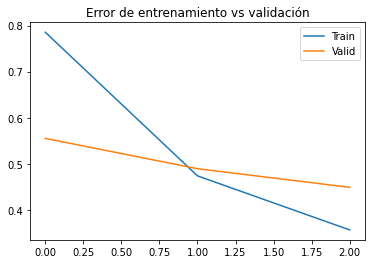

In [40]:
plt.plot(history["train_loss"])
plt.plot(history["valid_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

Con el modelo sin preentrenar tuvo una mejor performance pero tuve que evitar el overfitting haciendo data augmentation dado que el modelo es más complejo que el desarrollado en la clase 2. Con muy pocas épocas se llega a un 83% de accuary para validación. 